In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import cv2
import pandas as pd
from tensorflow.keras.datasets import cifar10, fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import datetime as dt
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:
dt.datetime.now()

datetime.datetime(2020, 4, 25, 4, 45, 38, 802708)

In [3]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4648122478202578255
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16751419708948643943
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
def load_preprocess():
    ### Load In Data
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    trainY = tf.keras.utils.to_categorical(trainY)
    testY = tf.keras.utils.to_categorical(testY)
    return [trainX/255, trainY, testX/255, testY]
def scheduler(epoch):
    if epochs>10:
        return 0.001
    else: 
        return 0.001*tf.math.exp(0.1*(10-epoch))

In [5]:
trainX, trainY, testX, testY = load_preprocess()
trainX = np.expand_dims(trainX, axis = -1)
testX = np.expand_dims(testX, axis = -1)

In [6]:
im_size =28
channels = 1
num_classes = 10
lr = 0.001 ### learning rate
input_shape = ( im_size, im_size, channels)
l1_lambda = 0 ### L1 regularization lambda parameter
l2_lambda = 0.01
keep_prob = 0.3

In [7]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, GaussianNoise, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1

from tensorflow.keras.layers import BatchNormalization, Conv2D, GaussianNoise, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1

### Creating model architecture
he_init = tf.keras.initializers.VarianceScaling()
model = Sequential()
#model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(28, (3, 3),input_shape=input_shape,activation='relu',
                 kernel_initializer =he_init))


model.add(Conv2D(32, (3, 3),activation='relu',kernel_initializer =he_init))
model.add(GaussianNoise(0.01))
model.add(Conv2D(32, (3, 3),input_shape=input_shape,activation='relu',
                 kernel_initializer =he_init))
#model.add(GaussianNoise(0.01))
model.add(Conv2D(32, (3, 3),activation='relu',kernel_initializer =he_init))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(keep_prob))
model.add(Conv2D(64, (3, 3),activation='relu', kernel_initializer =he_init))
model.add(Conv2D(64, (3, 3),activation='relu', kernel_initializer =he_init))
model.add(GaussianNoise(0.01))
model.add(Conv2D(64, (3, 3),activation='relu', kernel_initializer =he_init))
model.add(Conv2D(64, (3, 3),activation='relu', kernel_initializer =he_init))
model.add(BatchNormalization())

model.add(
    Conv2D(128, (3, 3), activation='relu', kernel_initializer =he_init))
model.add(
    Conv2D(128, (3, 3), activation='relu', kernel_initializer =he_init))

#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(keep_prob))
model.add(
    Conv2D(256, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                 kernel_initializer =he_init))

model.add(GaussianNoise(0.1))
model.add(
    Conv2D(256,(3, 3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                 kernel_initializer =he_init))
#model.add(BatchNormalization(input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(keep_prob))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                kernel_initializer =he_init))
model.add(Dropout(keep_prob))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                kernel_initializer =he_init))
model.add(Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                kernel_initializer =he_init))
model.add(Dropout(keep_prob))
#model.add(GaussianNoise(0.01))
model.add(Dense(num_classes, activation='softmax', kernel_initializer =he_init))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 28)        280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        8096      
_________________________________________________________________
gaussian_noise (GaussianNois (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 20, 20, 32)        0

from tensorflow.keras.models import model_from_json
# load json and create model
#json_file = open('Models/model_fine_labels.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("Models/model_fine_labels.h5")
print("Loaded model from disk")

In [8]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=True, # divide each input by its std
        #rotation_range = 30,
        #vertical_flip = True,
        #horizontal_flip = True, 
       # brightness_range = [0.7, 1.2]
)
test_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
)

In [9]:
trainX.shape

(60000, 28, 28, 1)

In [10]:
train_datagen.fit(trainX)
test_datagen.fit(testX)

In [11]:
it = train_datagen.flow(trainX, trainY,
                                 batch_size=2)

In [12]:
x = it.next()

In [13]:
x[0].shape

(2, 28, 28, 1)

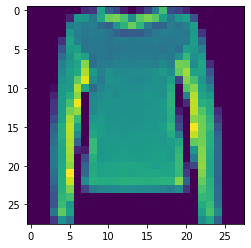

In [14]:
plt.imshow(x[0][0].reshape(28,28))

In [17]:
epochs = 50
batch_size = 512
check_point_path = 'Models/checkpoints'
### Instantiate Callbacks
callback1 = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback2  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                  patience=5, min_lr=0.001)
callback3 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto',
    baseline=None,  restore_best_weights=True
)
callback4 = tf.keras.callbacks.ModelCheckpoint(
    check_point_path, monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch'
)
lr = 0.00001
###Compile and run Model
model.compile(optimizer = tf.keras.optimizers.Adam(lr),
              loss = "categorical_crossentropy",  metrics= ['accuracy'])

history = model.fit_generator(train_datagen.flow(trainX, trainY,
                                 batch_size=batch_size),
                    epochs=epochs,validation_data=test_datagen.flow(testX, testY),workers=4
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 118 steps, validate for 313 steps
Epoch 1/50
118/118 [==============================] - 21s 176ms/step - loss: 0.2289 - accuracy: 0.9428 - val_loss: 0.3649 - val_accuracy: 0.9031
Epoch 2/50
118/118 [==============================] - 20s 168ms/step - loss: 0.2262 - accuracy: 0.9441 - val_loss: 0.3677 - val_accuracy: 0.9018
Epoch 3/50
118/118 [==============================] - 21s 176ms/step - loss: 0.2232 - accuracy: 0.9446 - val_loss: 0.3650 - val_accuracy: 0.9045
Epoch 4/50
118/118 [==============================] - 21s 177ms/step - loss: 0.2250 - accuracy: 0.9435 - val_loss: 0.3661 - val_accuracy: 0.9022
Epoch 5/50
118/118 [==============================] - 21s 179ms/step - loss: 0.2223 - accuracy: 0.9437 - val_loss: 0.3660 - val_accuracy: 0.9051
Epoch 6/50
118/118 [==============================] - 21s 182ms/step - loss: 0.2216 - accuracy: 0.9447 - val_loss: 0.3690 - val_accuracy: 0.9043
Epoch 7/50
118/118 [================

KeyboardInterrupt: 

In [22]:
model.evaluate(test_datagen.flow(testX, testY))

  ...
    to  
  ['...']
313/313 [==============================] - ETA: 0s - loss: 0.3733 - accuracy: 0.90 - 22s 69ms/step - loss: 0.3750 - accuracy: 0.9032


[0.3750247732518961, 0.9032]

50


Text(0, 0.5, 'Validation Loss')

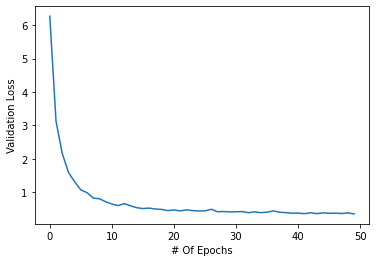

In [18]:
num = len(history.history['val_loss'])
type(history.history)
history.history.keys()
print(len(history.history['val_loss']))
plt.plot([i for i in range(len(history.history['val_loss']))],history.history['val_loss'])
plt.xlabel("# Of Epochs")
plt.ylabel("Validation Loss")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
50


Text(0, 0.5, 'Loss')

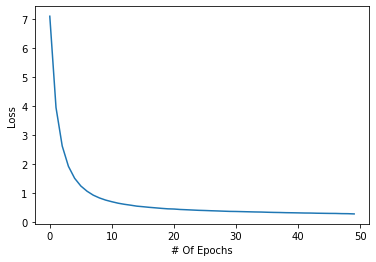

In [19]:
type(history.history)
print(history.history.keys())
print(len(history.history['val_loss']))
plt.plot([i for i in range(len(history.history['loss']))],history.history['loss'])
plt.xlabel("# Of Epochs")
plt.ylabel("Loss")

<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, **kwargs)>

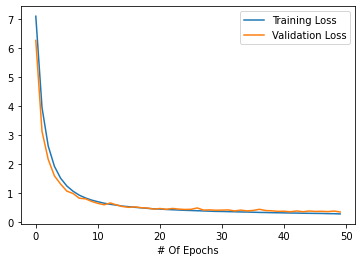

In [20]:
plt.plot([i for i in range(len(history.history['loss']))],history.history['loss'])
plt.plot([i for i in range(len(history.history['val_loss']))],history.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel("# Of Epochs")
plt.ylabel

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_fashion_90acc1.png')


scores = model.evaluate(test_datagen.flow(testX, testY), verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


# Serialize model to JSON
model_json = model.to_json()
with open("Models/model_fashion_90acc1.json", "w") as json_file:
    json_file.write(model_json)
# Serialize weights to HDF5
model.save_weights("Models/model_fashion_90acc1.h5")
print("Saved model to disk")


  ...
    to  
  ['...']
313/313 [==============================] - 22s 69ms/step - loss: 0.3737 - accuracy: 0.9032
accuracy: 90.32%
Saved model to disk


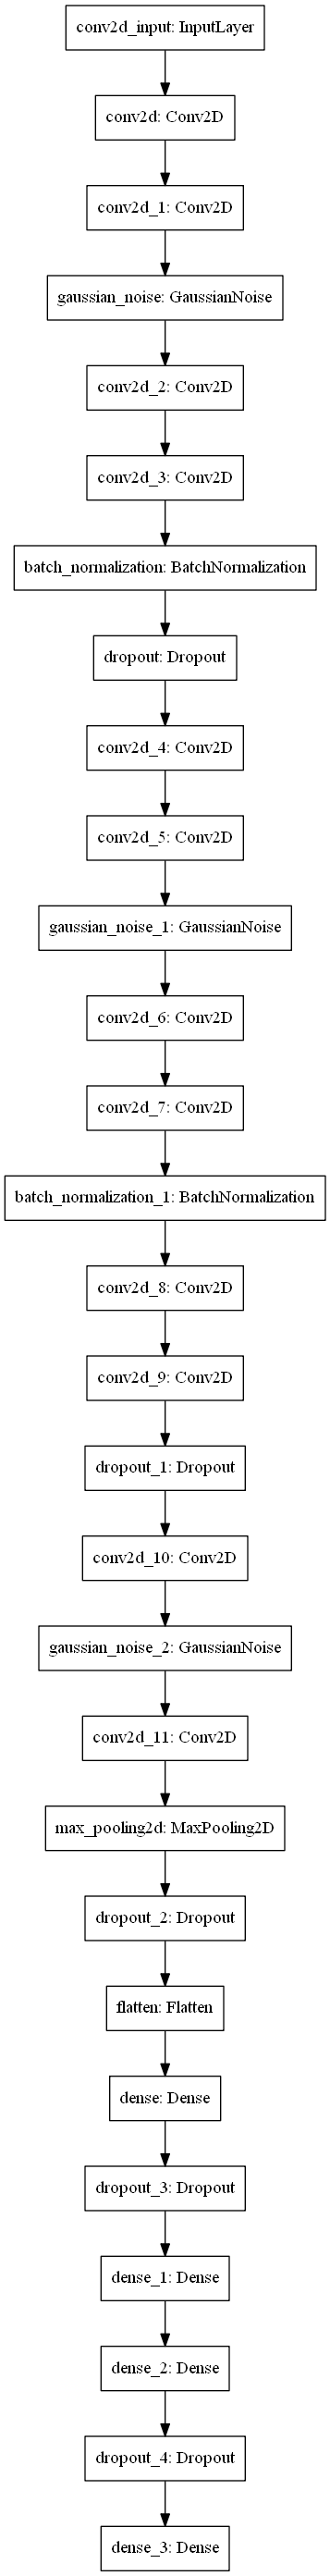

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [26]:
print("-Confusion matrix")
confuse = tf.math.confusion_matrix(np.argmax(ytest,axis = 1), np.argmax(pred, axis = 1), num_classes = 100)


-Confusion matrix


NameError: name 'ytest' is not defined

In [55]:
import sys
import numpy
numpy.set_printoptions(threshold=np.inf)
print(confuse)

tf.Tensor(
[[72  1  1  1  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
   0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  1  4  0  0 10  0  0  0  0  0  0  0  0  0  0  0  1  1  0
   0  0  0  0  0  0  1  0  0  0  0  7  0  0  0  0  0  0  0  0  3  0  0  0
   0  1  0  0]
 [ 0 51  3  0  1  0  0  1  0  0  0  0  0  1  2  0  0  0  1  1  0  0  0  1
   0  0  2  0  0  2  1  0  1  2  0  0  0  1  0  0  0  0  0  0  1  1  0  0
   1  1  1  0  0  2  0  0  0  1  0  0  0  0  3  0  0  1  0  2  0  0  2  0
   0  1  2  0  0  2  0  0  0  0  1  0  0  0  0  0  0  0  2  2  2  4  0  0
   2  0  1  1]
 [ 0  0 31  0  0  0  0  0  0  0  1  4  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  2  0  1  0  2  0  1  0  1  6  3  0  2  0  0  0  0  1  2  1  4  0
   0  0  2  0  0  0  0  0  0  0  0  0  0  2  0  0  2  1  1  0  0  0  0  0
   0  0  0  0  2  1  3  0  1  1  0  0  0  0  1  0  0  0  0  0  0  1  0  0
   0  1  6  0]
 [ 0  1  0 26  1  0  0  2  0  0  0  0  0  1  0  1  0  0 